In [7]:
import numpy as np
import pandas as pd

# EDA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings(action='ignore')

# font
plt.rc('font', family='gulim') # For Windows

In [10]:

# train_col = ['num','datetime','target','temperature','windspeed','humidity','precipitation','insolation','nelec_cool_flag','solar_flag']
train_col = ['num', 'date_time', 'target', 'temp', 'wind', 'humid', 'rain', 'sunny', 'cooler', 'solar']

train = pd.read_csv('./data/train.csv', encoding='utf8', names=train_col, header=0)
train.head(10)

,num,date_time,target,temp,wind,humid,rain,sunny,cooler,solar
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
5,1,2020-06-01 05,8010.576,16.9,3.4,93.0,0.0,0.0,0.0,0.0
6,1,2020-06-01 06,7978.176,16.7,3.4,90.0,0.1,0.0,0.0,0.0
7,1,2020-06-01 07,8019.000,16.9,2.3,86.0,0.0,0.1,0.0,0.0
8,1,2020-06-01 08,8020.944,17.8,3.3,80.0,0.0,0.3,0.0,0.0
9,1,2020-06-01 09,8083.152,19.3,2.1,73.0,0.0,0.7,0.0,0.0


In [11]:
# date_time에 따른 feature 추가
train['date_time'] = pd.to_datetime(train['date_time'])
train['date'] = train['date_time'].dt.date
train['day'] = train['date_time'].dt.day
train['month'] = train['date_time'].dt.month
train['hour'] = train['date_time'].dt.hour
train['weekday'] = train['date_time'].dt.weekday # 0: 월요일
train['weekend'] = train['weekday'].isin([5,6]).astype(int) # 주말
train['dayofyear'] = train.date_time.dt.dayofyear            # 연 기준 몇일째(숫자)
train.head()

,num,date_time,target,temp,wind,humid,rain,sunny,cooler,solar,date,day,month,hour,weekday,weekend,dayofyear
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,2020-06-01,1,6,0,0,0,153
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,2020-06-01,1,6,1,0,0,153
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01,1,6,2,0,0,153
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01,1,6,3,0,0,153
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,2020-06-01,1,6,4,0,0,153


In [12]:
train_origin = train.copy()

In [13]:
# 정확한 군집화를 위한 스케일링
for i in range(1, 61):
    mean_ = train.loc[train.num == i].target.mean() # 평균
    std_ = train.loc[train.num == i].target.std()   # 표준편차
    train.loc[train.num == i, 'target'] = ((train.loc[train.num == i, 'target']) - mean_) / std_

In [14]:
# 요일에 따른 평균 값 산출
weekday_mean = (
    train.groupby(['num', 'weekday'])['target'].mean()
    .reset_index()
    .pivot('num', 'weekday', 'target')
    .reset_index()
)

In [15]:
# 시간에 따른 평균 값 산출
hour_mean = (
    train.groupby(['num', 'hour'])['target'].mean()
    .reset_index()
    .pivot('num', 'hour', 'target')
    .reset_index()
    .drop('num', axis=1)
)

In [16]:
# 요일별, 시간별 평균 전력 사용량 테이블 구축
cl_df = pd.concat([weekday_mean, hour_mean], axis=1)

In [17]:
# 보기 편하게 컬럼 이름 지정
columns = (
    ['num']
    + ['mon','tue','wed','thu','fri','sat','sun'] 
    + [str(i)+'h' for i in range(24)]
)

cl_df.columns = columns

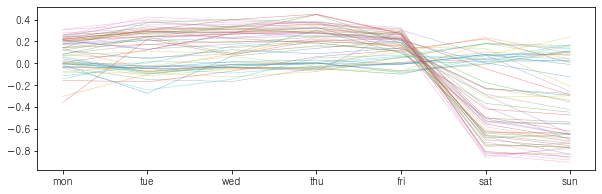

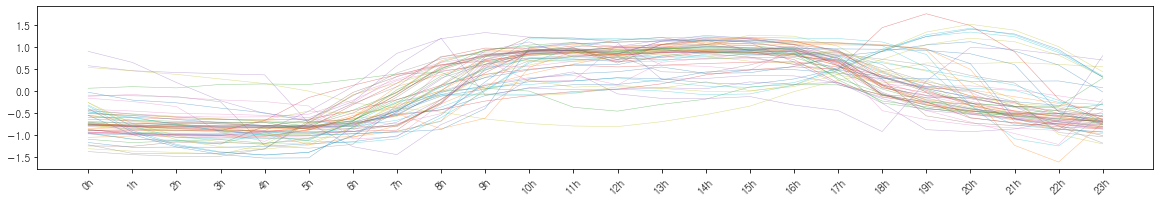

In [18]:
# 시각화를 통한 확인
fig = plt.figure(figsize = (10,3))
for i in range(len(cl_df)):
    plt.plot(cl_df.iloc[i, 1:8], alpha = 0.5, linewidth = 0.5)
    
fig = plt.figure(figsize = (20,3))
for i in range(len(cl_df)):
    plt.plot(cl_df.iloc[i, 8:32], alpha = 0.5, linewidth = 0.5)
    plt.xticks(rotation=45)

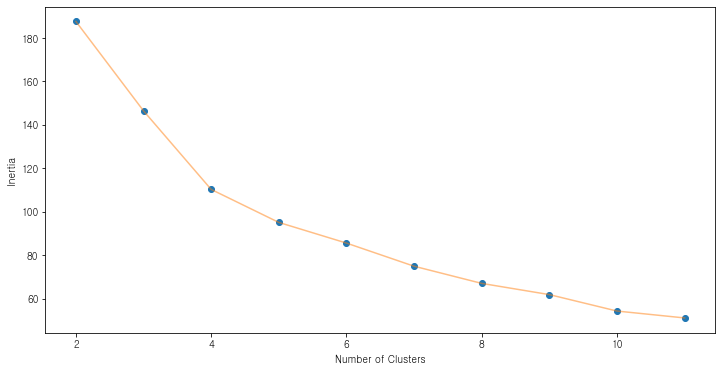

In [19]:
# elbow method를 통해 군집의 개수 결정
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1 , figsize = (12, 6))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], cl_df.iloc[:,1:])

In [20]:
# 엘보우 포인트를 통해 kmeans 클러스터링
model = KMeans(n_clusters = 4, random_state = 42)
pred = model.fit_predict(cl_df.iloc[:, 1:])

In [22]:
# 값 할당
cl_df['km_cluster'] = pred

# 기존 train set과 merge
train_cl = pd.merge(train, cl_df[['num', 'km_cluster']], how='left', on='num')

In [23]:
# 군집별 분석을 위한 4개의 데이터셋 할당
km_0 = list(train_cl.loc[train_cl.km_cluster == 0].num.unique())
km_1 = list(train_cl.loc[train_cl.km_cluster == 1].num.unique())
km_2 = list(train_cl.loc[train_cl.km_cluster == 2].num.unique())
km_3 = list(train_cl.loc[train_cl.km_cluster == 3].num.unique())

In [24]:
train_cl.groupby(['km_cluster'])['num'].count().to_frame()/2040   # .to_frame() : 프레임으로 만들어 보여주는것, /2040: 정규화

,num
km_cluster,
0,7.0
1,33.0
2,5.0
3,15.0


In [25]:
train_cl

,num,date_time,target,temp,wind,humid,rain,sunny,cooler,solar,date,day,month,hour,weekday,weekend,dayofyear,km_cluster
0,1,2020-06-01 00:00:00,-2.795969,17.6,2.5,92.0,0.8,0.0,0.0,0.0,2020-06-01,1,6,0,0,0,153,2
1,1,2020-06-01 01:00:00,-3.129259,17.7,2.9,91.0,0.3,0.0,0.0,0.0,2020-06-01,1,6,1,0,0,153,2
2,1,2020-06-01 02:00:00,-3.348135,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01,1,6,2,0,0,153,2
3,1,2020-06-01 03:00:00,-3.795838,17.1,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01,1,6,3,0,0,153,2
4,1,2020-06-01 04:00:00,-3.835633,17.0,3.3,92.0,0.0,0.0,0.0,0.0,2020-06-01,1,6,4,0,0,153,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,1.840746,27.8,2.3,68.0,0.0,0.7,1.0,1.0,2020-08-24,24,8,19,0,0,237,3
122396,60,2020-08-24 20:00:00,1.504699,27.3,1.2,71.0,0.0,0.0,1.0,1.0,2020-08-24,24,8,20,0,0,237,3
122397,60,2020-08-24 21:00:00,0.526918,27.3,1.8,71.0,0.0,0.0,1.0,1.0,2020-08-24,24,8,21,0,0,237,3
122398,60,2020-08-24 22:00:00,-0.134708,27.1,1.8,74.0,0.0,0.0,1.0,1.0,2020-08-24,24,8,22,0,0,237,3
